In [50]:
import pandas as pd
train_set = pd.read_csv(r"C:\Users\Hieu\Desktop\titanic\train.csv")
test_set = pd.read_csv(r"C:\Users\Hieu\Desktop\titanic\test.csv")
passengerId= test_set.PassengerId

In [51]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set on axis 0
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

In [52]:
df_all = concat_df(train_set, test_set)

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

In [54]:
all_numerical= df_all.select_dtypes(include=['float64','int64'])

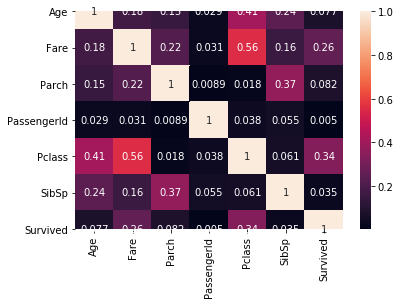

In [55]:
sns.heatmap(all_numerical.corr().abs(), annot=True)
plt.show()

In [56]:
age_by_pclass= df_all.groupby('Pclass')['Age'].mean()
age_by_pclass

Pclass
1    39.159930
2    29.506705
3    24.816367
Name: Age, dtype: float64

In [57]:
df_all['Age'] = df_all.groupby('Pclass')['Age'].apply(lambda x: x.fillna(x.median()))

In [58]:
df_all['Embarked'] = df_all['Embarked'].fillna('S')

In [59]:
df_all['Fare']= df_all['Fare'].fillna(df_all['Fare'].mean())

In [60]:
df_all.isnull().sum()

Age               0
Cabin          1014
Embarked          0
Fare              0
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [61]:
df_all['Family'] = df_all['SibSp'] + df_all['Parch']

In [62]:
df_all['Title'] = df_all.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
df_all['Title'] = df_all['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', \
                                                 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

df_all['Title'] = df_all['Title'].replace('Mlle', 'Miss')
df_all['Title'] = df_all['Title'].replace('Ms', 'Miss')
df_all['Title'] = df_all['Title'].replace('Mme', 'Mrs')
df_all.Title.value_counts()

Mr        757
Miss      264
Mrs       198
Master     61
Rare       29
Name: Title, dtype: int64

In [63]:
df_all= df_all.drop(['Cabin','Name','Ticket','PassengerId','SibSp','Parch'],axis=1)

In [64]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
ohe.fit_transform(df_all[['Sex','Embarked','Title']])

array([[0., 1., 0., ..., 1., 0., 0.],
       [1., 0., 1., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

In [65]:
df_train, df_test = divide_df(df_all)
y=df_train.Survived
X= df_train.drop('Survived',axis=1)

In [66]:
from sklearn.compose import make_column_transformer
column_trans = make_column_transformer(
    (OneHotEncoder(), ['Sex', 'Embarked','Title']),
    remainder='passthrough')

In [194]:
X=column_trans.fit_transform(X)

In [67]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=0, solver='lbfgs',max_iter=1000)

In [196]:
param_grid = dict(C=C_range)
print(param_grid)

{'C': [0.001, 0.01, 0.1, 1, 10]}


In [197]:
from sklearn.model_selection import GridSearchCV
C_range = list([0.001, 0.01, 0.1, 1,10])
print(C_range)

[0.001, 0.01, 0.1, 1, 10]


In [198]:
grid = GridSearchCV(model, param_grid, cv=10, scoring='accuracy', return_train_score=False)
grid.fit(X,y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=0, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [199]:
pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]

,mean_test_score,std_test_score,params
0,0.683502,0.048374,{'C': 0.001}
1,0.772166,0.047895,{'C': 0.01}
2,0.803591,0.023143,{'C': 0.1}
3,0.802469,0.019065,{'C': 1}
4,0.800224,0.020479,{'C': 10}


In [200]:
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.8035914702581369
{'C': 0.1}
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [68]:
from sklearn.pipeline import make_pipeline
model = LogisticRegression(random_state=0, solver='lbfgs',max_iter=1000)
pipe = make_pipeline(column_trans, model)

In [69]:
X= df_train.drop('Survived',axis=1)

In [70]:
pipe.fit(X,y)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categorical_features=None,
                                                                categories=None,
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='error',
                                                                n_values=None,
                                                                sparse=True),
                                                  ['Sex', 'Embarked',
                         

In [71]:
predictions= pipe.predict(df_test).astype(int)
print(predictions)

[0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 1 1 1 0 1 0 0 0 0 0 0 1 0 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 0 1 1
 1 1 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 1 0 1 0 1 1 0 1 1 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 1 0 0 1 0 1 0 0 1 0 1 1 0 0 0
 0 1 1 1 1 1 0 1 0 0 1]


In [72]:
from sklearn.model_selection import cross_val_score
cross_val_score(pipe, X, y, cv=5, scoring='accuracy').mean()

0.8249369544579077

In [73]:
output = pd.DataFrame({'PassengerId': passengerId,
                            'Survived': predictions})
output.to_csv(r'C:\Users\Hieu\submission.csv', index=False)